In [1]:
import star_functions as nana

In [2]:
import importlib
importlib.reload(nana)

<module 'star_functions' from '/Users/nana/venv/hoggnation/oscillator_catalog/star_functions.py'>

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import numpy as np
from astropy import units as u

In [5]:
star_files = glob.glob("*.dat")

In [6]:
print(star_files)
#kplr010536147

['kplr005309849_pixeldata_manualdetrended.dat', 'kplr004939281_pixeldata_manualdetrended.dat', 'kplr003865742.dat', 'kplr004930889.dat', 'kplr010526294.dat', 'kplr005941844_pixeldata_manualdetrended.dat', 'kplr006462033_pixeldata_manualdetrended.dat', 'kplr011971405_pixeldata_tilloutburst.dat', 'kplr007760680_pixeldata_filtered_manualdetrended.dat', 'kplr009020774.dat', 'kplr006352430.dat', 'kplr010536147.dat', 'kplr008459899.dat', 'kplr003459297.dat', 'kplr008714886.dat', 'kplr003240411.dat', 'kplr008057661.dat', 'kplr012258330.dat', 'kplr011360704.dat', 'kplr008255796_pixeldata_manualdetrended.dat', 'kplr008766405.dat', 'kplr004936089_pixeldata_manualdetrended.dat', 'kplr006780397_pixeldata_manualdetrended.dat', 'kplr007630417_pixeldata_manualdetrended.dat', 'kplr009715425_pixeldata_manualdetrended_full_v2.dat', 'kplr008381949.dat']


In [7]:
def do_one_star(star_fn, exptime = 'long'):
    
    star = star_fn[:13] #brittle

    print("working on ", star)
    
    #pipeline 
    lc, delta_f, sampling_time, exptime = nana.star(star, exptime = exptime)
    print("delta_f:", delta_f)
    print("sampling_time:", sampling_time)
    if lc is None:
        return 
    f_max = (3 / (2*sampling_time))
    f_min = delta_f/3
    t_fit, flux_fit, weight_fit = nana.mask_vals(lc)
    freq_full, power_full = nana.pg_full(f_min, f_max, lc)
    freq_mini, power_mini = nana.pg_mini(f_min, f_max, lc )
    indices = nana.get_filtered_peaks(12, freq_mini, power_mini)
    refined_freq, refined_power, second_derivatives = nana.refine_peaks(freq_mini, power_mini, indices)
    fc = nana.folding_freq(delta_f, freq_full, power_full, sampling_time, False)
    regions, final_freqs, chi2s = nana.region_and_freq(indices, fc, f_min, freq_mini, power_mini, t_fit, flux_fit, weight_fit, exptime)
    '''
    plt.plot(freq_full, power_full, 'k.')
    plt.scatter(final_freqs, refined_power, color = 'red', marker = 'o')
    plt.show()
    
    plt.plot(freq_mini, power_mini, 'g-')
    plt.semilogy()
    plt.show()
    '''
    a_early, a_late, b_early, b_late = nana.check_coherence(t_fit, flux_fit, weight_fit, final_freqs, exptime)
    rate_of_phase, rate_of_amp = nana.change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit)
    delta_chi2s = nana.null_chi_squared(flux_fit, weight_fit) - chi2s
    sharpnesses = nana.sharpness(second_derivatives, refined_power)
    
    '''
    data = Table()


    data['modes'] = final_freqs
    data['regions'] = regions
    data['corresponding_freq_in_region_A'] = refined_freq
    data['sharpness'] = sharpnesses
    data['delta_chi_squares'] = delta_chi2s
    data['rate_of_change_of_phase'] = rate_of_phase
    data['rate_of_change_of_amplitude'] = rate_of_amp
    
    ascii.write(
        data,
        star + '.csv',
        overwrite=True,
        format="csv",
        formats={
            "modes": "{:.10f}",
            "corresponding_freq_in_region_A": "{:.5f}",
            "sharpness": "{:.7e}",
            "delta_chi_squares": "{:.7e}",
            "rate_of_change_of_phase": "{:.7e}",
            "rate_of_change_of_amplitude": "{:.7e}"
        }
    )
    '''

    return
    

In [8]:
##out of spec stars
#kplr006462033
#kplr010536147
#kplr008459899
#kplr003459297
#kplr003240411
#kplr012258330
#

In [9]:
#out of spec stars
#kplr006462033
#kplr010536147
#kplr008459899
#kplr003240411
#kplr012258330
#kplr008766405

In [10]:
#for star in star_files:
  #  do_one_star(star, exptime = exptime)

In [11]:
def check_coherence2(ts, ys, weights, oms, T):

    Qs = [[[ ] , [ ]] for i in range(4)]

    ts_median = np.median(ts)
    t_first = np.median(ts[ts < ts_median])
    t_third = np.median(ts[ts >= ts_median])

    mask_q1 = (ts < ts_median) & (ts < t_first)
    mask_q2 = (ts < ts_median) & (ts >= t_first)
    mask_q3 = (ts >= ts_median) & (ts < t_third)
    mask_q4 = (ts >= ts_median) & (ts >= t_third)

    cases = [mask_q1, mask_q2, mask_q3, mask_q4]
    
    for om in oms:
        for q, I in zip(Qs, cases):
            A = nana.integral_design_matrix(ts[I], om, T)
            pars, _ =nana.weighted_least_squares_new(A, ys[I], weights[I])
            q[0].append(pars[1])
            q[1].append(pars[2])

    return Qs[0], Qs[1], Qs[2], Qs[3]
            



delta_f: 0.0006800582572566702
sampling_time: 0.02043360086827306


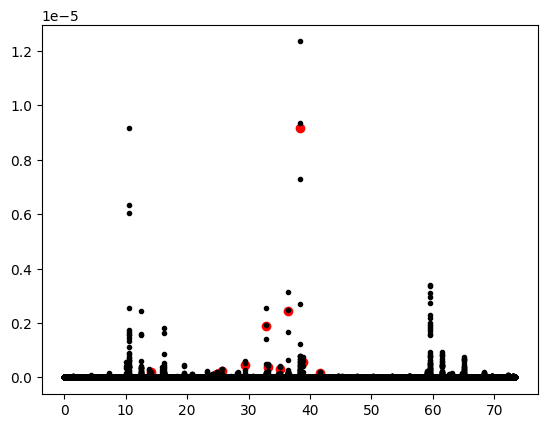

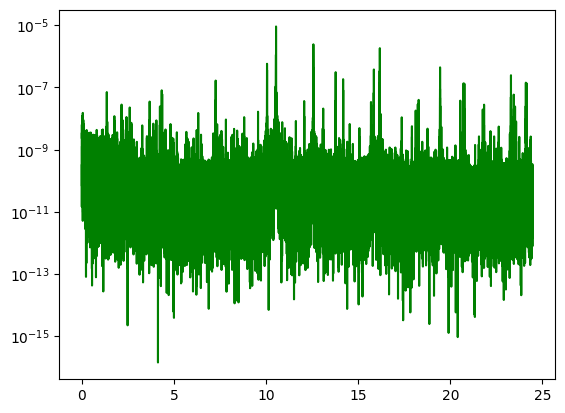

In [5]:
#og KIC 520 star star
lc, delta_f, sampling_time, exptime520 = nana.star('KIC 5202905')
print("delta_f:", delta_f)
print("sampling_time:", sampling_time)
#if lc is None:
    #return 
f_max = (3 / (2*sampling_time))
f_min = delta_f/3
t_fit520, flux_fit520, weight_fit520 = nana.mask_vals(lc)
freq_full, power_full = nana.pg_full(f_min, f_max, lc)
freq_mini, power_mini = nana.pg_mini(f_min, f_max, lc )
indices = nana.get_filtered_peaks(12, freq_mini, power_mini)
refined_freq, refined_power, second_derivatives = nana.refine_peaks(freq_mini, power_mini, indices)
fc = nana.folding_freq(delta_f, freq_full, power_full, sampling_time, False)
regions, final_freqs520, chi2s = nana.region_and_freq(indices, fc, f_min, freq_mini, power_mini, t_fit520, flux_fit520, weight_fit520, exptime520)

plt.plot(freq_full, power_full, 'k.')
plt.scatter(final_freqs520, refined_power, color = 'red', marker = 'o')
plt.show()

plt.plot(freq_mini, power_mini, 'g-')
plt.semilogy()
plt.show()

a_early, a_late, b_early, b_late = nana.check_coherence(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)
rate_of_phase, rate_of_amp = nana.change_in_phase_and_amp(a_early, a_late, b_early, b_late, t_fit520)
delta_chi2s = nana.null_chi_squared(flux_fit520, weight_fit520) - chi2s
sharpnesses = nana.sharpness(second_derivatives, refined_power)

In [15]:
arrays = check_coherence_test(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)
#print(arrays)

In [16]:
import matplotlib.ticker as ticker

In [37]:
##coherence test all:
def coherence_test_all(ts, ys, weights, final_freq, T):

    oms = np.array([f * 2 * np.pi for f in final_freq])
    all = np.zeros((len(oms), 2))
    half = np.zeros((len(oms), 2, 2))
    quartiles = np.zeros((len(oms), 4, 2))
    jackknives = np.zeros((len(oms), 8, 2))


    ##alls
    for idx, om in enumerate(oms):
        A = nana.integral_design_matrix(ts, om, T)
        pars, _ = nana.weighted_least_squares_new(A, ys, weights)
        all[idx][0] = pars[1]
        all[idx][1] = pars[2]
        
    ##Cases half and half
    ts_median = np.median(ts)
    I_early = ts < ts_median
    I_late  = ts > ts_median

    cases = [I_early, I_late]
    for idx, om in enumerate(oms):
        for i, I in enumerate(cases):

            print(I)
            
            A = nana.integral_design_matrix(ts[I], om, T)
            pars, _ = nana.weighted_least_squares_new(A, ys[I], weights[I])
            half[idx][i][0] = pars[1]
            half[idx][i][1] = pars[2]
    
    ##cases for quartile
    t_first = np.median(ts[ts < ts_median])
    t_third = np.median(ts[ts >= ts_median])
    
    mask_q1 = (ts < ts_median) & (ts < t_first)
    mask_q2 = (ts < ts_median) & (ts >= t_first)
    mask_q3 = (ts >= ts_median) & (ts < t_third)
    mask_q4 = (ts >= ts_median) & (ts >= t_third)
    
    cases = [mask_q1, mask_q2, mask_q3, mask_q4]

    for idx, om in enumerate(oms):
        for i, I in enumerate(cases):
            A = nana.integral_design_matrix(ts[I], om, T)
            pars, _ = nana.weighted_least_squares_new(A, ys[I], weights[I])
            quartiles[idx][i][0] = pars[1]
            quartiles[idx][i][1] = pars[2]

    return all, half, quartiles
    
    ##all points
    
    
        
    
    
    

In [24]:
all, half, quartiles = coherence_test_all(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)
#print(all, half, quartiles)

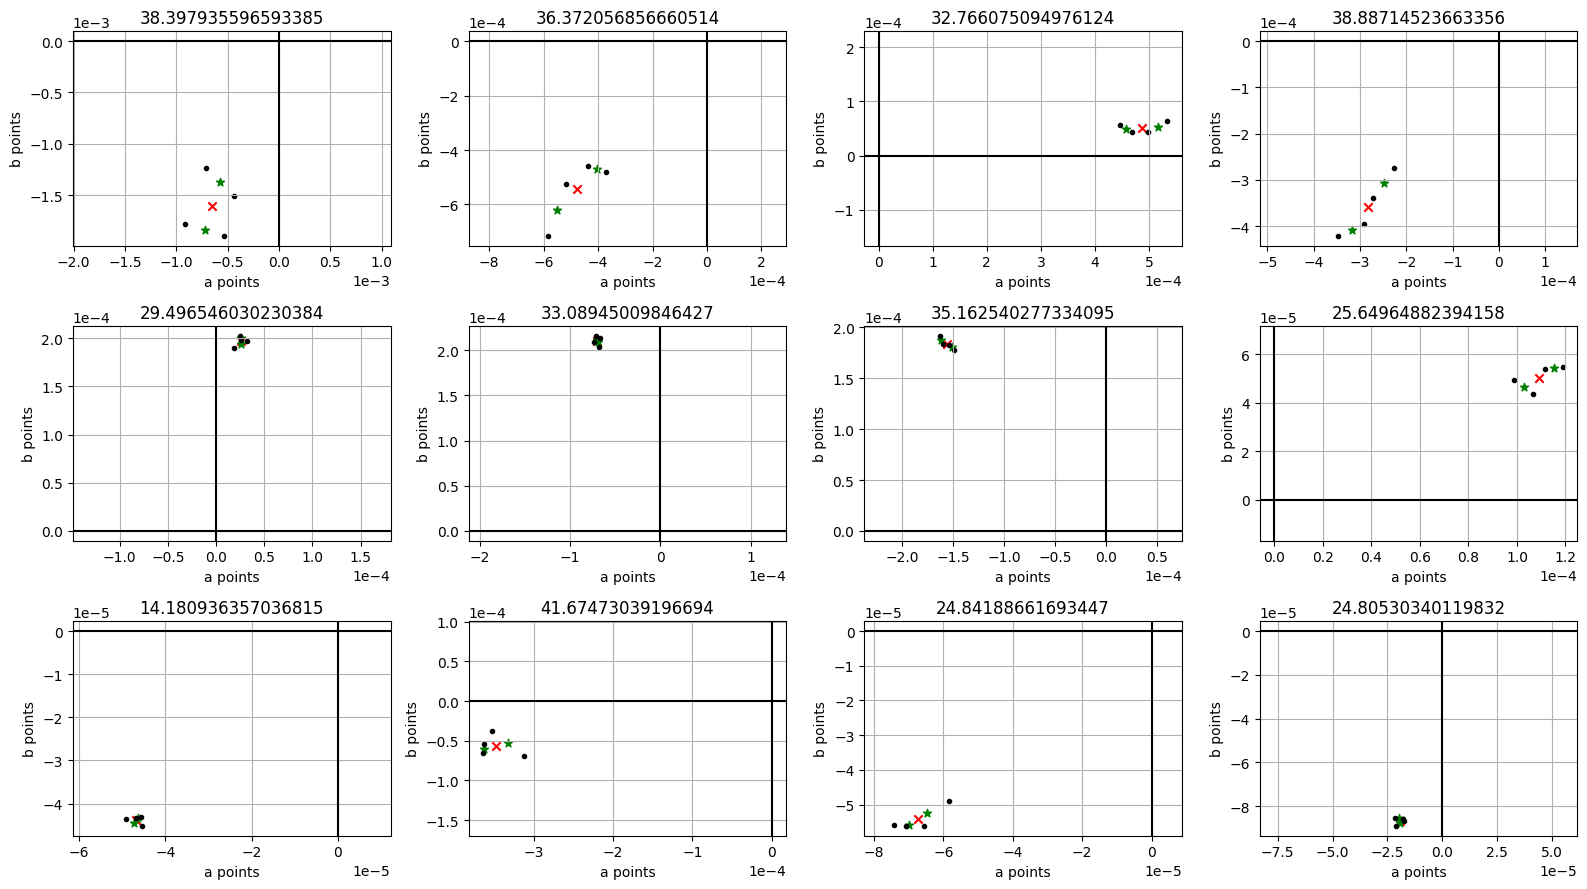

In [82]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))

for idx, (ax, points1, points2, points3) in enumerate(zip(axes.flat, all, half, quartiles)):
    a_all = points1[0]  
    b_all = points1[1]  

    a_half = points2[:, 0]  
    b_half = points2[:, 1]  

    a_quarter = points3[:, 0]  
    b_quarter = points3[:, 1]  

    ax.scatter(a_all, b_all, color = 'red', marker='x')
    ax.scatter(a_half, b_half, color = 'green', marker = '*')
    ax.scatter(a_quarter, b_quarter, color = 'k', marker = '.')
    
    ax.axvline(0, color = 'k')
    ax.axhline(0, color = 'k')
    ax.set_title(final_freqs520[idx])
    ax.set_xlabel("a points")
    ax.set_ylabel("b points")
    ax.grid(True)
    ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
    ax.axis('equal')



plt.tight_layout()


In [93]:
subsample = (np.arange(371)//(np.ceil(371/8))).astype(int)

In [94]:
print(np.unique(subsample, return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([47, 47, 47, 47, 47, 47, 47, 42]))


In [6]:
##make code pretty, and add jacknives
##and compute stats

##splitting

def splitting(ts, group_num, return_counts = True, jackknives = True):

    indices = np.argsort(ts)
    counts = np.zeros(group_num, dtype=int)
    split_indices = np.array_split(indices, group_num)

    if jackknives == True:
        masks = np.ones((group_num, len(ts)), dtype=bool) #makes everything true by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = False
            counts[i] = len(idx)

        return (masks, counts) if return_counts else masks
    
    else:
        masks = np.zeros((group_num, len(ts)), dtype=bool) #makes everything false by default
        for i, idx in enumerate(split_indices):
            masks[i, idx] = True
            counts[i] = len(idx)

    return (masks, counts) if return_counts else masks

In [7]:
splitting(t_fit520, 8, True, True)

(array([[False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False, False]], shape=(8, 52283)),
 array([6536, 6536, 6536, 6535, 6535, 6535, 6535, 6535]))

In [13]:
##making the coherence test all better

##coherence test all:
def coherence_testing(ts, ys, weights, final_freq, T):

    oms = np.array([f * 2 * np.pi for f in final_freq])
    all = np.zeros((len(oms), 2))
    half = np.zeros((len(oms), 2, 2))
    quartiles = np.zeros((len(oms), 4, 2))
    eighths = np.zeros((len(oms), 8, 2))

    ##alls
    for idx, om in enumerate(oms):
        A = nana.integral_design_matrix(ts, om, T)
        pars, _ = nana.weighted_least_squares_new(A, ys, weights)
        all[idx][0] = pars[1]
        all[idx][1] = pars[2]
        
    ##Cases half

    masks2, counts = splitting(ts, 2, return_counts=True, jackknives = False)

    for idx, om in enumerate(oms):
        for i, mask in enumerate(masks2):
            
            A = nana.integral_design_matrix(ts[mask], om, T)
            pars, _ = nana.weighted_least_squares_new(A, ys[mask], weights[mask])
            half[idx][i][0] = pars[1]
            half[idx][i][1] = pars[2]

    ##cases for quartile
    masks4, counts = splitting(ts, 4, return_counts=True, jackknives = False)
    
    for idx, om in enumerate(oms):
        for i, mask in enumerate(masks4):
            A = nana.integral_design_matrix(ts[mask], om, T)
            pars, _ = nana.weighted_least_squares_new(A, ys[mask], weights[mask])
            quartiles[idx][i][0] = pars[1]
            quartiles[idx][i][1] = pars[2]

    ##jacknives and eighths
    masks8, counts = splitting(ts, 8, return_counts=True, jackknives = True)
    
    for idx, om in enumerate(oms):
        for i, mask in enumerate(masks8):
            A = nana.integral_design_matrix(ts[mask], om, T)
            pars, _ = nana.weighted_least_squares_new(A, ys[mask], weights[mask])
            eighths[idx][i][0] = pars[1]
            eighths[idx][i][1] = pars[2]   

    return all, half, quartiles, eighths
        


In [32]:
all, half, quartiles, eighths = coherence_all(t_fit520, flux_fit520, weight_fit520, final_freqs520, exptime520)

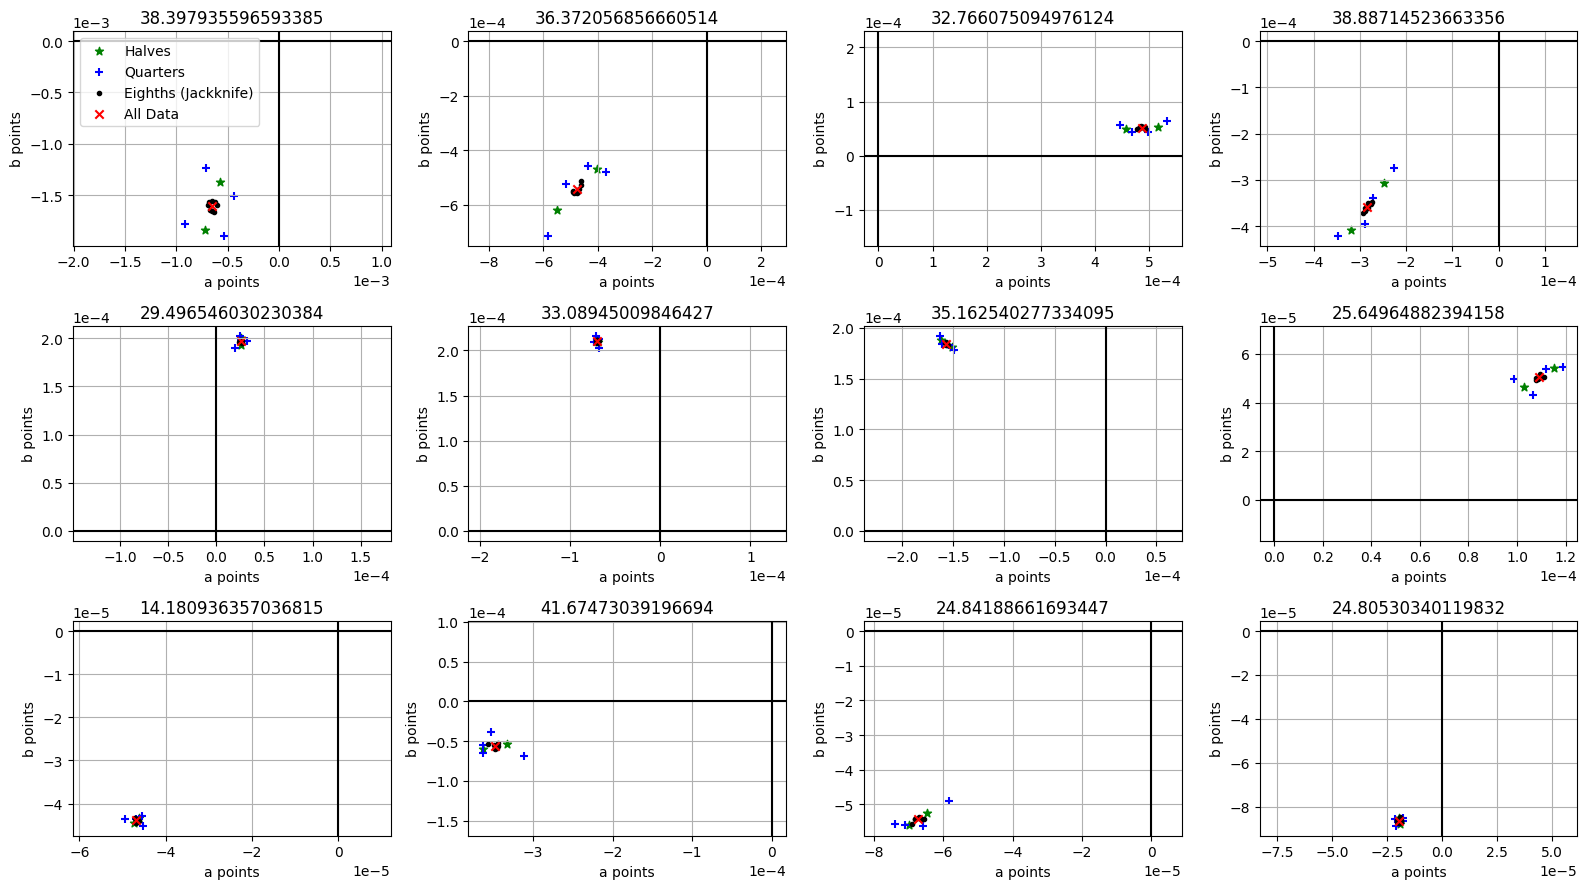

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))

for idx, (ax, points1, points2, points3, points4) in enumerate(zip(axes.flat, all, half, quartiles, eighths)):
    a_all = points1[0]  
    b_all = points1[1]  

    a_half = points2[:, 0]  
    b_half = points2[:, 1]  

    a_quarter = points3[:, 0]  
    b_quarter = points3[:, 1] 

    a_eighth = points4[:, 0]
    b_eighth= points4[:, 1]

    ax.scatter(a_half, b_half, color='green', marker='*', label='Halves')
    ax.scatter(a_quarter, b_quarter, color='blue', marker='+', label='Quarters')
    ax.scatter(a_eighth, b_eighth, color='k', marker='.', label='Eighths (Jackknife)')
    ax.scatter(a_all, b_all, color='red', marker='x', label='All Data')

    if idx == 0:
        ax.legend()
    
    ax.axvline(0, color = 'k')
    ax.axhline(0, color = 'k')
    ax.set_title(final_freqs520[idx])
    ax.set_xlabel("a points")
    ax.set_ylabel("b points")
    ax.grid(True)
    ax.ticklabel_format(style='sci', scilimits=(-3, 3), axis='both')
    ax.axis('equal')



plt.tight_layout()


In [31]:
###FINAL COHERENCE TEST!!!!
def coherence_all(ts, ys, weights, final_freq, T):
    oms = np.array([f * 2 * np.pi for f in final_freq])
    all = np.zeros((len(oms), 2))

    for idx, om in enumerate(oms):
        A = nana.integral_design_matrix(ts, om, T)
        pars, _ = nana.weighted_least_squares_new(A, ys, weights)
        all[idx][0] = pars[1]
        all[idx][1] = pars[2]
        

    splits = np.array([2, 4, 8])
    results = [np.zeros((len(oms), n, 2)) for n in splits]
    
    for split, result in zip(splits, results):     

        jack = (split == 8)
        masks, counts = splitting(ts, split, return_counts=True, jackknives = jack)
        for idx, om in enumerate(oms):
            for i, mask in enumerate(masks):
                A = nana.integral_design_matrix(ts[mask], om, T)
                pars, _ = nana.weighted_least_squares_new(A, ys[mask], weights[mask])
                result[idx][i][0] = pars[1]
                result[idx][i][1] = pars[2]

    return all, results[0], results[1], results[2] #all, half, quarter, eighth (+jacknives)
    